In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

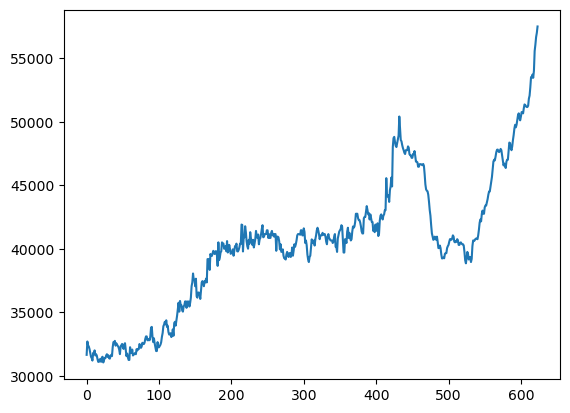

In [2]:
# load dataset
series = pd.read_excel('data_export.xlsx')
series.drop(series.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)
values = series.values
# plot dataset
plt.plot(values)
plt.show()

In [3]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [4]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [18]:
# calculate metrics
def print_metrics(test, pre_test):
    print('\nRMSE')
#     trainScore = np.sqrt(mean_squared_error(train, pre_train))
#     print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('Test Score: %.2f RMSE' % (testScore))
    print('\nMAE')
#     trainScore = sklearn.metrics.mean_absolute_error(train, pre_train)
#     print('Train Score: %.2f MAE' % (trainScore))
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('Test Score: %.2f MAE' % (testScore))
    print('\nMAPE')                          
#     trainScore = sklearn.metrics.mean_absolute_percentage_error(train, pre_train)
#     print('Train Score: %.2f MAPE' % (trainScore))
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('Test Score: %.2f MAPE' % (testScore))
    print('\nMASE')
#     trainScore = mean_absolute_scaled_error(train, pre_train, train)
#     print('Train Score: %.2f MASE' % (trainScore))
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('Test Score: %.2f MASE' % (testScore))

In [19]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, test_size = n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    print_metrics(test[:, -1], predictions)
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

In [20]:
data = series_to_supervised(values, n_in=6)

In [22]:
data

array([[31667.5, 32717. , 32417. , ..., 32117. , 31817. , 31517. ],
       [32717. , 32417. , 32317. , ..., 31817. , 31517. , 31417. ],
       [32417. , 32317. , 32117. , ..., 31517. , 31417. , 31217. ],
       ...,
       [53466.5, 53716.5, 53466.5, ..., 55566.5, 56066.5, 56666.5],
       [53716.5, 53466.5, 54016.5, ..., 56066.5, 56666.5, 57000. ],
       [53466.5, 54016.5, 55566.5, ..., 56666.5, 57000. , 57500. ]])

In [21]:
mae, y, yhat = walk_forward_validation(data, 0.2)


RMSE
Test Score: 422.18 RMSE

MAE
Test Score: 340.49 MAE

MAPE
Test Score: 0.01 MAPE

MASE


NameError: name 'mean_absolute_scaled_error' is not defined

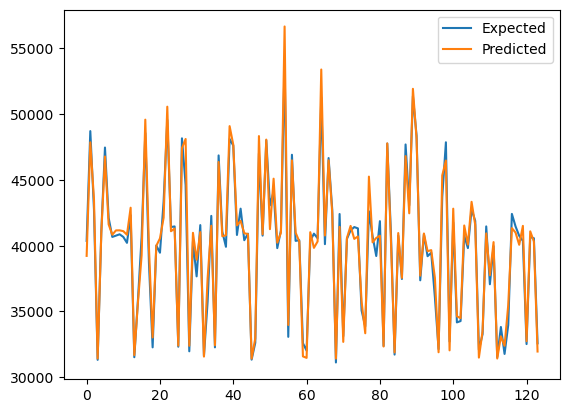

In [15]:
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()